Image Compression Project
Task
⦁	The user will upload the image and give the parameters, them the algorithm have to compress the image without losing any pixels and size. The Parameters are Height, Width, Name….etc.. The output should be a compressed image without losing any pixels and size.


In [1]:
!pip install tensorflow-compression
![[ -e /tfc ]] || git clone https://github.com/tensorflow/compression /tfc
%cd /tfc/models
import tfci  # Check if tfci.py is available.

/tfc/models


## Enabling GPU

GPU should be enabled for this colab. If the next cell prints a warning, do the following:
- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [2]:
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
  print('WARNING: No GPU found. Might be slow!')
else:
  print('Found GPU.')

Found GPU.


## Imports and Definitions

In [3]:
import os
import zipfile
from google.colab import files
import collections
from PIL import Image
from IPython.display import Image as DisplayImage
from IPython.display import Javascript
from IPython.core.display import display, HTML
import tfci
import urllib.request

tf.get_logger().setLevel('WARN')  # Only show Warnings

FILES_DIR = '/content/files'
OUT_DIR = '/content/out'
DEFAULT_IMAGE_URL = ('https://storage.googleapis.com/hific/clic2020/'
                     'images/originals/ad249bba099568403dc6b97bc37f8d74.png')

os.makedirs(FILES_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

File = collections.namedtuple('File', ['full_path', 'num_bytes', 'bpp'])

def print_html(html):
  display(HTML(html + '<br/>'))

def make_cell_large():
  display(Javascript(
      '''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

def get_default_image(output_dir):
  output_path = os.path.join(output_dir, os.path.basename(DEFAULT_IMAGE_URL))
  print('Downloading', DEFAULT_IMAGE_URL, '\n->', output_path)
  urllib.request.urlretrieve(DEFAULT_IMAGE_URL, output_path)



## Load files

In [4]:
#@title Setup { vertical-output: false, run: "auto", display-mode: "form" }
#@markdown #### Custom Images
#@markdown Tick the following if you want to upload your own images to compress.
#@markdown Otherwise, a default image will be used.
#@markdown 
#@markdown **Note**: We support JPG and PNG (without alpha channels).

#@markdown 

upload_custom_images = False #@param {type:"boolean", label:"HI"}

if upload_custom_images:
  uploaded = files.upload()
  for name, content in uploaded.items():
    with open(os.path.join(FILES_DIR, name), 'wb') as fout:
      print('Writing', name, '...')
      fout.write(content)

#@markdown #### Select a model
#@markdown Different models target different bitrates.

model = 'hific-hi' #@param ["hific-lo", "hific-mi", "hific-hi"]



In [5]:
#@title Loading Images { vertical-output: false, run: "auto", display-mode: "form" }
#@markdown Tick the following if you want to upload your own images to compress.
#@markdown Otherwise, a default image will be used.
#@markdown 
#@markdown **Note**: We support JPG and PNG (without alpha channels).
#@markdown 

upload_custom_images = False #@param {type:"boolean"}

if upload_custom_images:
  uploaded = files.upload()
  for name, content in uploaded.items():
    with open(os.path.join(FILES_DIR, name), 'wb') as fout:
      print('Writing', name, '...')
      fout.write(content)

-> /content/files/ad249bba099568403dc6b97bc37f8d74.png

Got the following files (1):
- ad249bba099568403dc6b97bc37f8d74.png:


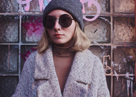

Width: 2048 	 Height: 1459
bpp: 14.010139114976011
Size: 5232.843 kB


In [9]:
all_files = os.listdir(FILES_DIR)
if not upload_custom_images or not all_files:
  print('Downloading default image...')
  get_default_image(FILES_DIR)
  print()

all_files = os.listdir(FILES_DIR)
print(f'Got the following files ({len(all_files)}):')

for file_name in all_files:
  img = Image.open(os.path.join(FILES_DIR, file_name))
  w, h = img.size
  img = img.resize((w // 15, h // 15))
  print('- ' + file_name + ':')
  display(img)
  num_bytes = os.path.getsize(os.path.join(FILES_DIR, file_name))
  print("Width:",w,'\t',"Height:",h)
  print("bpp:",num_bytes * 8 / (w * h))
  print("Size:",(num_bytes/1000),"kB")

##Compress images

In [7]:
SUPPORTED_EXT = {'.png', '.jpg'}

all_files = os.listdir(FILES_DIR)
if not all_files:
  raise ValueError("Please upload images!")

def get_bpp(image_dimensions, num_bytes):
  w, h = image_dimensions
  return num_bytes * 8 / (w * h)

def has_alpha(img_p):
  im = Image.open(img_p)
  return im.mode == 'RGBA'

all_outputs = []
for file_name in all_files:
  if os.path.isdir(file_name):
    continue
  if not any(file_name.endswith(ext) for ext in SUPPORTED_EXT):
    print('Skipping', file_name, '...')
    continue
  full_path = os.path.join(FILES_DIR, file_name)
  if has_alpha(full_path):
    print('Skipping because of alpha channel:', file_name)
    continue
  file_name, _ = os.path.splitext(file_name)

  compressed_path = os.path.join(OUT_DIR, f'{file_name}_{model}.tfci')
  output_path = os.path.join(OUT_DIR, f'{file_name}_{model}.png')
  
  if os.path.isfile(output_path):
    print('Exists already:', output_path)
    num_bytes = os.path.getsize(compressed_path)
    all_outputs.append(
      File(output_path, num_bytes,
           get_bpp(Image.open(full_path).size, num_bytes)))
    continue

  print('Compressing', file_name, 'with', model, '...')
  tfci.compress(model, full_path, compressed_path)
  num_bytes = os.path.getsize(compressed_path)
  print(f'Compressed to {num_bytes} bytes.')

  print('Decompressing...')
  tfci.decompress(compressed_path, output_path)
  
  all_outputs.append(
      File(output_path, num_bytes,
           get_bpp(Image.open(full_path).size, num_bytes)))

print('All done!')

Compressing ad249bba099568403dc6b97bc37f8d74 with hific-hi ...
Compressed to 202403 bytes.
Decompressing...
All done!


# Show output

In [10]:
make_cell_large()  # Larger output window.

for file in all_outputs:
  print_html('<hr/>')
  print(f'Showing {file.full_path} | {file.num_bytes//1000}kB | {file.bpp:.4f}bpp')
  img_com = Image.open(file.full_path)
  display(Image.open(file.full_path))
  print_html('<hr/>')
  w,h = img_com.size
  print("Width:",w,'\t',"Height",h)

Output hidden; open in https://colab.research.google.com to view.

### Download all compressed images.

To download all images, run the following cell.

You can also use the _Files_ tab on the left to manually select images.

---

#### **Note**: the images are saved as PNGs and thus very large. The bitrate used by HiFiC is given in the name.

In [9]:
ZIP = '/content/images.zip'

with zipfile.ZipFile(ZIP, 'w') as zf:
  for f in all_outputs:
    path_with_bpp = f.full_path.replace('.png', f'-{f.bpp:.3f}bpp.png')
    zf.write(f.full_path, os.path.basename(path_with_bpp))

files.download(ZIP) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>